In [50]:
import os, glob, numpy as np, joblib as jl, pandas as pd, \
    matplotlib.pyplot as plt, simplification.cutil as simpl, numba as nb
from scipy.stats import mode
from scipy.optimize import minimize
from tqdm import tqdm_notebook as tqdm
from plotnine import *
import warnings
import seaborn as sns
import regex as re
from sklearn.cluster import AgglomerativeClustering
warnings.filterwarnings('ignore')

### Outward -> Inward

In [2]:
# Load data
fnames = glob.glob('C:/Users/acorver/Desktop/data-tmp/radiidata_*.metrics.pickle')
len(fnames)

21

In [350]:
data = []

angleMerging = []

for recid, fn in enumerate(fnames):
    
    # Is this a canonical recording?
    st = jl.load(fn.replace('.metrics', ''))['recinfo']['stages']['radii'][0]
    iscanonical = isinstance(st, list) or isinstance(st, tuple)

    dRadii = jl.load(fn)
    dRadii.angle = dRadii.angleZeroIntercept

    # Obtain inward-going radii segment angles and their relative distances
    angles = np.sort(dRadii[(dRadii.stagerep==0)&(~dRadii.outward)].angle)
    distMtx = np.zeros((angles.size, angles.size))
    for i0 in range(angles.size):
        for i1 in range(angles.size):
            dst = abs(angles[i0] - angles[i1])
            dst = min(dst, 2 * np.pi - dst)
            distMtx[i0, i1] = dst * 180 / np.pi

    # Agglomeratively group radii traversals into predicted physically unique radii
    cl = AgglomerativeClustering(n_clusters = None, compute_full_tree=True, 
        distance_threshold = 7, linkage='complete', affinity='precomputed').fit_predict(distMtx)

    anglesNew = []
    for clId in np.unique(cl):
        angl = angles[cl == clId] * 180 / np.pi
        # Use the angle with smallest distance to edge
        bestAngl = 0
        bestAnglDst = 1e6
        for a in np.arange(0, 360, 1):
            maxDist = 0
            for a2 in angl:
                dst = abs(a2 - a)
                dst = min(dst, 360 - dst)
                maxDist = max(dst, maxDist)
            if maxDist < bestAnglDst:
                bestAnglDst = maxDist
                bestAngl = a
        anglesNew.append(bestAngl)
    
    # Store merging for debugging purposes
    angleMerging.append((angles, anglesNew))
    
    # Obtain radii spacing
    anglesNew = np.sort(anglesNew)
    a = abs(anglesNew[0] - anglesNew[-1])
    a = min(a, 360 - a)
    radiiSpacing = np.hstack((np.diff(anglesNew), a))

    # Store
    for rs in radiiSpacing:
        data.append((recid, iscanonical, rs))
        
data = pd.DataFrame(data, columns=['recid', 'canonical', 'angle'])
data.loc[:,'numradii'] = data.groupby('recid').transform('count').angle

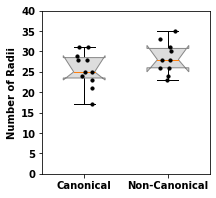

In [364]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))

for iscanonical in [True, False]:
    yvals = np.array(data[data.canonical==iscanonical].groupby(
        'recid').mean().numradii.values.astype(int))
    ax.boxplot(yvals, patch_artist=True, bootstrap=10000, widths=[0.5,],
        notch=True, vert=True, boxprops={
            'facecolor': '#dddddd', 'edgecolor': '#888888'}, whis=(0,100), positions=[1 - int(iscanonical),])
    
    xvals = np.random.random(size=yvals.size) * 0.2 - 0.1 + (1 - int(iscanonical))
    ax.scatter(xvals, yvals, s=10, color='black', zorder=10)

ax.set_xticklabels(['Canonical', 'Non-Canonical'])
ax.set_ylabel('Number of Radii')
ax.set_ylim(0, 40)

fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_radii_count.pdf')

In [352]:
# Source: http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html
def bootstrap(data, n=1000, func=np.nanmean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

In [353]:
nbins = max(
    np.histogram(data.angle[ data.canonical], bins='fd', range=(0, 90))[0].size,
    np.histogram(data.angle[~data.canonical], bins='fd', range=(0, 90))[0].size)

histCIs = []
for iscanonical in [True, False]:
    # Compute histogram with same binning and range
    hists = np.array([np.histogram(data.angle[(data.canonical==iscanonical)&(data.recid==recid)], 
        bins=nbins, range=(0, 90))[0] for recid in data.recid[data.canonical==iscanonical].unique()])
    # Compute CI
    histCI = np.array([bootstrap(hists[:,i])(0.95) for i in range(hists.shape[1])])
    means = np.array([np.mean(hists[:,i]) for i in range(hists.shape[1])])
    histCIs.append(np.hstack((histCI, means[:,np.newaxis])))

In [354]:
edges = np.histogram([], bins=nbins, range=(0, 90))[1]
edges = edges[1:] * 0.5 + edges[:-1] * 0.5

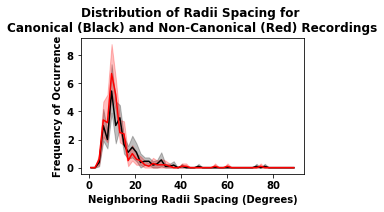

In [363]:
fig, ax = plt.subplots(1, 1, figsize=(4,2.5))

ax.fill_between(edges, histCIs[0][:,0], histCIs[0][:,1], color='black', alpha=0.25)
ax.plot        (edges, histCIs[0][:,2], color='black')
ax.fill_between(edges, histCIs[1][:,0], histCIs[1][:,1], color='red', alpha=0.25)
ax.plot        (edges, histCIs[1][:,2], color='red')

ax.set_xlabel('Neighboring Radii Spacing (Degrees)')
ax.set_ylabel('Frequency of Occurrence')
ax.set_title('Distribution of Radii Spacing for \nCanonical (Black) and Non-Canonical (Red) Recordings')

fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_radii_spacing_distribution.pdf')

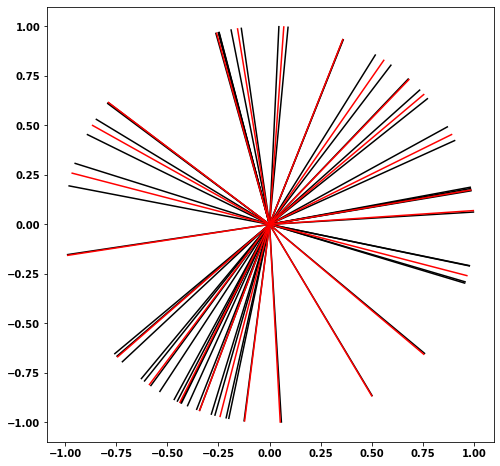

In [357]:
angles, anglesNew = angleMerging[15]
fig, ax = plt.subplots(1, 1, figsize=(8,8))
for a in angles * 180 / np.pi:
    plt.plot([0, np.cos(a * np.pi / 180)], [0, np.sin(a * np.pi / 180)], color='black')
for a in anglesNew:
    plt.plot([0, np.cos(a * np.pi / 180)], [0, np.sin(a * np.pi / 180)], color='red', zorder=10)